In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob

PRESSURE_VARIABLES=[
    "geopotential",
    "u_component_of_wind",
    "v_component_of_wind",
    "specific_humidity",
    "temperature",
    "vertical_velocity"
]

SURFACE_VARIABLES=[
    "10m_u_component_of_wind", 
    "10m_v_component_of_wind", 
    "total_precipitation_6hr", 
    "mean_sea_level_pressure"
]

files_t2m = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/*/Temperature2m_2021-06-24.nc'))
files_t2m = [f for f in files_t2m if int(f.split('/')[-2]) <= 24 * 9]

files_slp = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/mslp/nc/*/MeanSeaLevelPressure_2021-06-24.nc'))
files_slp = [f for f in files_t2m if int(f.split('/')[-2]) <= 24 * 9]

files_t2m

['/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/120/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/144/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/168/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/192/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/216/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/24/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/48/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/72/Temperature2m_2021-06-24.nc',
 '/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/96/Temperature2m_2021-06-24.nc']

In [20]:
def weighted_mean(dataset:xr.Dataset):

    # for GC_* files
    if "level" in dataset.dims:
        dataset = dataset.resample(time="1D").mean().squeeze('batch')
        dataset = dataset.drop_vars(PRESSURE_VARIABLES + SURFACE_VARIABLES + ['level'])
        dataset["time"] = pd.date_range("2021-06-27", periods=7, freq="1D")
        dataset = dataset.rename({"time":"date"})

    # for nwp files
    elif "time" in dataset.dims:
        dataset = dataset.expand_dims(dim={'date': [dataset.time.values[0]]})
        dataset = dataset.rename({'time': 'ensemble'})
        dataset['ensemble'] = np.arange(1, 51)
        dataset.drop_dims('height')
    
    
    dataset = dataset.sel(lat=slice(25, 60), lon=slice(102.5, 150))
    weights = np.cos(np.deg2rad(dataset.lat))
    weights.name = "weights"
    weighted = dataset.weighted(weights)
    
    return weighted.mean(('lat', 'lon'))

nwp = xr.open_mfdataset(files_t2m, combine='by_coords', preprocess=weighted_mean).squeeze('height').drop_vars('height')
nwp = nwp.rename({"2t":"2m_temperature"}).compute()

no_perturb = xr.open_dataset("testdata/2021-06-26/GC_output.nc")
perturb_1 = xr.open_dataset("testdata/2021-06-26/GC_4var_1std.nc")
perturb_2 = xr.open_dataset("testdata/2021-06-26/GC_4var_0.1std.nc")
perturb_3 = xr.open_dataset("testdata/2021-06-26/GC_4var_3std.nc")
perturb_4 = xr.open_dataset("testdata/2021-06-26/GC_4var_0.001std.nc")
perturb_5 = xr.open_dataset("testdata/2021-06-26/GC_4var_5std.nc")

era5 = xr.open_dataset("/camdata2/ERA5/daily/t2m/2021.nc").rename({"time":"date", "latitude":"lat", "longitude":"lon"}).sel(date=slice("2021-06-27", "2021-07-03"))

no_perturb = weighted_mean(no_perturb.isel(time=slice(2, 31)))
perturb_1 = weighted_mean(perturb_1.isel(time=slice(2, 31)))
perturb_2 = weighted_mean(perturb_2.isel(time=slice(2, 31)))
perturb_3 = weighted_mean(perturb_3.isel(time=slice(2, 31)))
perturb_4 = weighted_mean(perturb_4.isel(time=slice(2, 31)))
perturb_5 = weighted_mean(perturb_5.isel(time=slice(2, 31)))

era5 = weighted_mean(era5)

KeyboardInterrupt: 

In [17]:
nwp = xr.open_mfdataset(files_t2m, combine='by_coords', preprocess=weighted_mean).squeeze('height').drop_vars('height')
nwp = nwp.rename({"2t":"2m_temperature"}).compute()
nwp

<xarray.Dataset>
Dimensions:         (date: 7, ensemble: 50)
Coordinates:
  * date            (date) datetime64[ns] 2021-06-25 2021-06-26 ... 2021-07-01
  * ensemble        (ensemble) int64 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
Data variables:
    2m_temperature  (date, ensemble) float64 nan nan nan nan ... nan nan nan nan

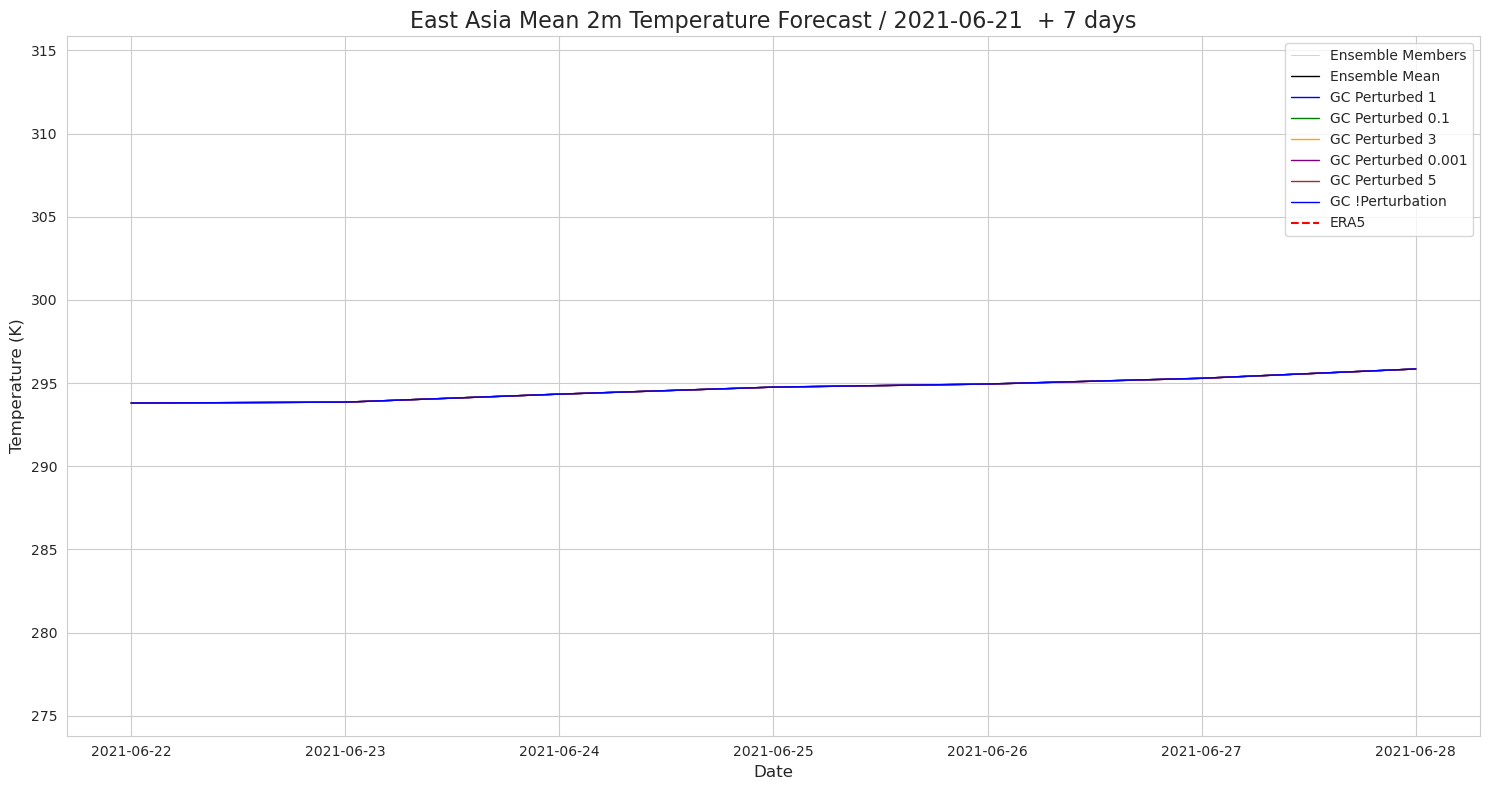

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

df = nwp['2m_temperature'].to_dataframe().reset_index()

first_ensemble = True
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    if first_ensemble:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5, label='Ensemble Members')
        first_ensemble = False
    else:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5)

mean_temp = df.groupby('date')['2m_temperature'].mean().reset_index()
plt.plot(mean_temp['date'], mean_temp['2m_temperature'], color='black', linewidth=1, label='Ensemble Mean')
plt.plot(perturb_1['date'], perturb_1['2m_temperature'], color='blue', linewidth=1, label='GC Perturbed 1')
plt.plot(perturb_2['date'], perturb_2['2m_temperature'], color='green', linewidth=1, label='GC Perturbed 0.1')
plt.plot(perturb_3['date'], perturb_3['2m_temperature'], color='orange', linewidth=1, label='GC Perturbed 3')
plt.plot(perturb_4['date'], perturb_4['2m_temperature'], color='purple', linewidth=1, label='GC Perturbed 0.001')
plt.plot(perturb_5['date'], perturb_5['2m_temperature'], color='brown', linewidth=1, label='GC Perturbed 5')
plt.plot(no_perturb['date'], no_perturb['2m_temperature'], color='#0000FF', linewidth=1, label='GC !Perturbation')
plt.plot(era5['date'], era5['t2m'], color='red', linewidth=1.5, linestyle='dashed', label='ERA5')
plt.title('East Asia Mean 2m Temperature Forecast / 2021-06-21  + 7 days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.legend(fontsize=10)

y_min = perturb_1['2m_temperature'].min() - 20

y_max = perturb_1['2m_temperature'].max() + 20
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('figure/2m_temperature_forecast_East Asia_0.001to5_2021-06-21.png')

In [ ]:

era5 = xr.open_dataset("/camdata2/ERA5/daily/t2m/2021.nc").rename({"time":"date"}).sel(date=slice("2021-06-22", "2021-06-30"))
era5

In [ ]:
perturb_test.time.astype('datetime64[ns]').values